In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils

import matplotlib.pyplot as plt

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [3]:
class VGG_19(nn.Module):
    def __init__(self):
        super(VGG_19, self).__init__()
        self.model = models.vgg19(pretrained=True).features[:30]
        
        for i, _ in enumerate(self.model):
            if i in [4, 9, 18, 27]:
                self.model[i] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
                
    def forward(self, x):
        features = []
        
        for i, layer in enumerate(self.model):
            x = layer(x)
            if i in [0, 5, 10, 19, 28]:
                features.append(x)
        return features
    
model = VGG_19().to(device)
for param in model.parameters():
    param.requires_grad = False

/Users/jamino/style-transfer/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jamino/style-transfer/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def load_img(path_to_image, img_size):
    img = Image.open(path_to_image)
    original_size = img.size
    
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    img = transform(img).unsqueeze(0)
    return img, original_size

def save_img(path_to_save, img, original_size):
    img = img.cpu().clone()
    img = img.squeeze(0)
    
    # address tensor value scaling and quantization
    img = torch.clamp(img, 0, 1)
    img = img.mul(255).byte()
    
    unloader = transforms.ToPILImage()
    img = unloader(img)
    
    img = img.resize(original_size, Image.Resampling.LANCZOS)
    
    img.save(path_to_save)

In [5]:
def transfer_style(iters, optimizer, alpha, beta, generated_image, content_image, style_image, show_images=False):
    for iter in range(iters+1):
        generated_features = model(generated_image)
        content_features = model(content_image)
        style_features = model(style_image)
        
        content_loss = 0
        style_loss = 0
        
        for generated_feature, content_feature, style_feature in zip(generated_features, content_features, style_features):
            batch_size, n_feature_maps, height, width = generated_feature.size()
            
            content_loss += (torch.mean((generated_feature - content_feature) ** 2))
            
            G = torch.mm((generated_feature.view(batch_size * n_feature_maps, height * width)), (generated_feature.view(batch_size * n_feature_maps, height * width)).t())
            A = torch.mm((style_feature.view(batch_size * n_feature_maps, height * width)), (style_feature.view(batch_size * n_feature_maps, height * width)).t())
            
            E_l = ((G - A) ** 2)
            w_l = 1/5
            style_loss += torch.mean(w_l * E_l)
            
        total_loss = alpha * content_loss + beta * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        

        if iter % 100 == 0:
            print('-'*15)
            print(f'\n{iter} \nTotal Loss: {total_loss.item()} \n Content Loss: {content_loss} \t Style Loss: {style_loss}')
            print('-'*15)
            
            if show_images == True:
                plt.figure(figsize=(10, 10))
                plt.imshow(generated_image.permute(0, 2, 3, 1)[0].cpu().detach().numpy())
                plt.show()
                
    return generated_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10000001..1.1].


---------------

0 
Total Loss: 150178848.0 
 Content Loss: 0.0 	 Style Loss: 150178848.0
---------------


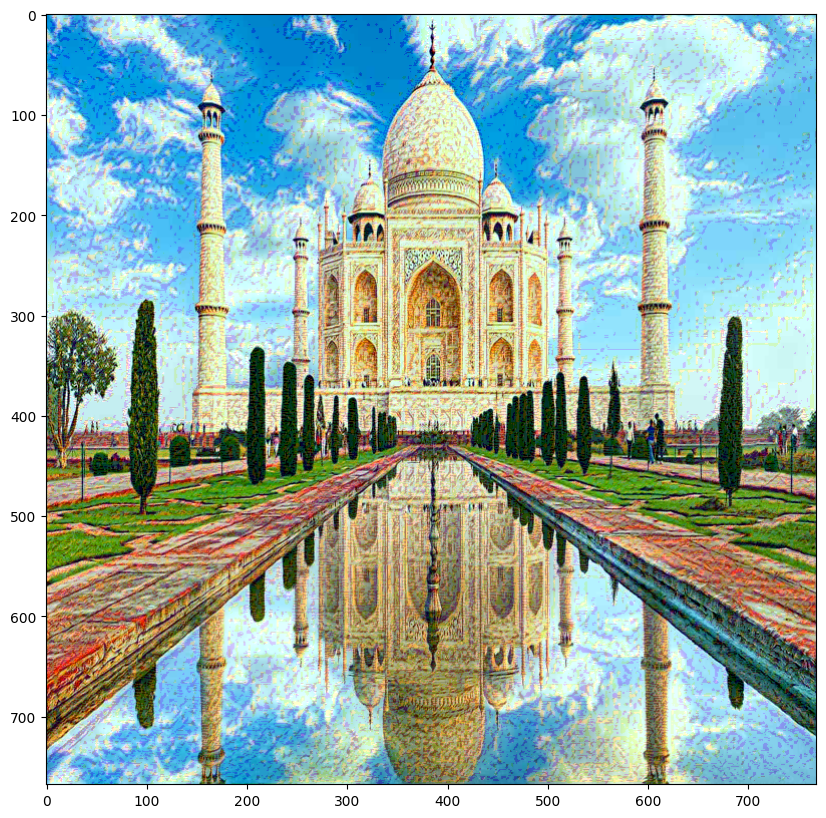

KeyboardInterrupt: 

In [6]:
content_img_filename = 'TajMahal.jpg'
style_img_filename = 'StarryNight.jpg'
img_size = 512
content_img, original_size = load_img(f'./input_images/{content_img_filename}', img_size)
content_img = content_img.to(device)
style_img = load_img(f'./style_images/{style_img_filename}', img_size)[0].to(device)

generated_init = content_img.clone().requires_grad_(True)

iterations = 100
lr = 1e-1
alpha = 1
beta = 1

optimizer = optim.Adam([generated_init], lr=lr)

generated_image = transfer_style(
    iterations, 
    optimizer, 
    alpha, 
    beta, 
    generated_init, 
    content_img, 
    style_img, 
    show_images=True
)

content_img_name, content_img_ext = content_img_filename.split('.')
save_img(
    f'./generated_images/{content_img_name}-{style_img_filename.split('.')[0]}.{content_img_ext}', 
    generated_image, 
    original_size
)